In [39]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import seaborn as sns
import folium

sns.set(style='darkgrid')
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
orange = (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)

In [6]:
cd ..

/home/tom/Documents/dsi/Capstone1/RestaurantInspections


In [7]:
from src.helper_funcs import *

In [9]:
# Set up dataframes
trim = setup_df('data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

### __Integrate median income per zip code data into our analysis__

In [10]:
trim_inc = get_income_df(trim)

In [ ]:
trim_inc

### Create a distribution plot of the incomes of zipcodes in NYC

In [13]:
search = SearchEngine()
zipcodes = list(trim['ZIPCODE'].dropna().unique())
zipcodes = list(map(int, zipcodes))
zipcodes = sorted(zipcodes)
zipcodes.remove(12345)
zipcodes.remove(30339)
zipdf = pd.DataFrame(zipcodes)
income = []
for zip_ in zipcodes:
    tosearch = search.by_zipcode(zip_)
    income.append(tosearch.median_household_income)

zipdf['Median_Income'] = income
zipdf.set_index(0, inplace=True)

In [14]:
zip_toplot = zipdf.drop(10000)
zip_toplot = zip_toplot.dropna()

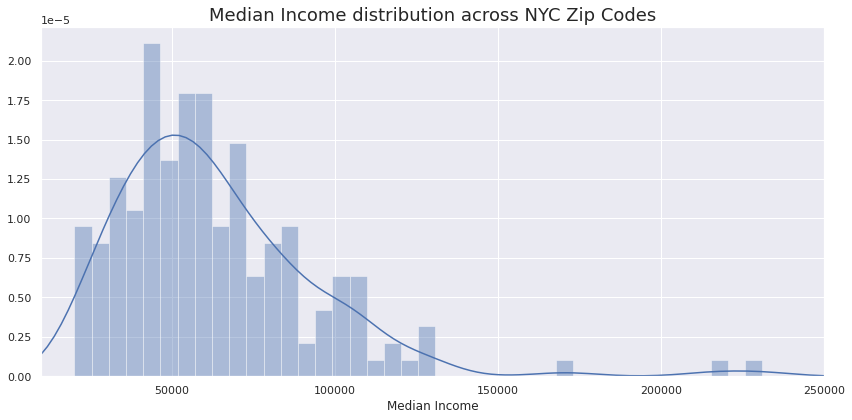

In [15]:
fig, ax = plt.subplots(figsize=(12,6))

sns.distplot(zip_toplot, bins = 40)
ax.set_xlim(10000, 250000)
ax.set_xlabel('Median Income')
plt.title('Median Income distribution across NYC Zip Codes', fontsize=18)

plt.tight_layout()
# plt.savefig('img/income_dist.png')
plt.show()

The above distribution is normal-looking, with a left skew and very long tail due to zip codes with median incomes > 200,000

### Let's also geo-plot the median incomes to further introduce this new data.

In [16]:
zip_map = zip_toplot.reset_index()
zip_map.rename({0: 'zip_code'}, axis=1, inplace=True)
zip_map['zip_code'] = zip_map['zip_code'].astype('str')

In [17]:
zip_map

,zip_code,Median_Income
0,10001,81671.0
1,10002,33218.0
2,10003,92540.0
3,10004,129313.0
4,10005,124670.0
...,...,...
175,11691,39409.0
176,11692,43354.0
177,11693,50570.0
178,11694,76944.0


In [19]:
ny_geo = 'data/nyc_zip_code_tabulation_areas_polygons.geojson'

In [20]:
map_income = choropleth_plot_income(ny_geo, zip_map, ['zip_code', 'Median_Income'])
map_income

/home/tom/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Set up unique restaurant dataframe, consisting of most recent inspection record in the dataset for each restaurant (24K unique businesses)

In [21]:
recent = trim_inc.groupby('CAMIS')['INSPECTION DATE'].max().reset_index()
recent.rename({'INSPECTION DATE': 'most_recent'}, inplace=True, axis=1)
recent.set_index('CAMIS', inplace=True)
trim_inc_recent = trim_inc.join(recent, on='CAMIS', how='left')
unique_df = trim_inc_recent[trim_inc_recent['INSPECTION DATE'] == trim_inc_recent.most_recent]
unique_df = unique_df.drop_duplicates(subset='CAMIS').reset_index().drop('index',axis=1)

In [22]:
unique_df.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,...,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Census Tract,Median_Income,most_recent
0,50051814,CORK & KALE AT EVEN HOTEL,Brooklyn,46,NEVINS STREET,11217,American,2019-04-02,Violations were cited in the following area(s).,10F,...,10.0,A,04/02/2019,10/25/2020,Cycle Inspection / Initial Inspection,40.687420,-73.981762,3700.0,81862.0,2019-04-02
1,41567472,AMC THEATRES,Manhattan,234,WEST 42 STREET,10036,American,2019-05-18,Violations were cited in the following area(s).,08A,...,12.0,A,05/18/2019,10/25/2020,Cycle Inspection / Initial Inspection,40.756740,-73.988659,11300.0,66599.0,2019-05-18
2,50003223,CAFE1 & CAFE 4 (AMERICAN MUSEUM OF NATURAL HIS...,Manhattan,NKA,CENTRL PARK WEST,10024,Sandwiches/Salads/Mixed Buffet,2019-07-30,Violations were cited in the following area(s).,04N,...,10.0,A,07/30/2019,10/25/2020,Cycle Inspection / Initial Inspection,NaN,NaN,NaN,109956.0,2019-07-30
3,41474503,SHAKE SHACK,Manhattan,300,WEST 44 STREET,10036,Hamburgers,2019-10-24,Violations were cited in the following area(s).,04N,...,11.0,A,10/24/2019,10/25/2020,Cycle Inspection / Initial Inspection,40.758700,-73.989276,12100.0,66599.0,2019-10-24
4,40736836,SILVER STAR RESTAURANT,Manhattan,1236,2 AVENUE,10065,American,2019-03-29,Violations were cited in the following area(s).,06F,...,7.0,A,03/29/2019,10/25/2020,Cycle Inspection / Initial Inspection,40.764205,-73.961706,11800.0,115519.0,2019-03-29


In [23]:
unique_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24859 entries, 0 to 24858
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   CAMIS                  24859 non-null  int64         
 1   DBA                    24859 non-null  object        
 2   BORO                   24859 non-null  object        
 3   BUILDING               24741 non-null  object        
 4   STREET                 24854 non-null  object        
 5   ZIPCODE                24859 non-null  int64         
 6   CUISINE DESCRIPTION    24859 non-null  object        
 7   INSPECTION DATE        24859 non-null  datetime64[ns]
 8   ACTION                 24859 non-null  object        
 9   VIOLATION CODE         24460 non-null  object        
 10  VIOLATION DESCRIPTION  24237 non-null  object        
 11  CRITICAL FLAG          24237 non-null  object        
 12  SCORE                  24259 non-null  float64       
 13  G

### Hypothesis test for differences in median incomes of the zipcodes of A, B, and C graded restaurants

In [24]:
unique_df.Median_Income.describe()

count     23821.000000
mean      66062.124596
std       28575.239761
min       20232.000000
25%       43996.000000
50%       59929.000000
75%       85324.000000
max      230952.000000
Name: Median_Income, dtype: float64

There are significant outliers in the income data, e.g. max = 230,952. Because of the left skew, let's trim 3 standard deviations to the right of the mean to make the distribution look visually comprehensible.

$ mean \approx 66,000 \\
std \approx 28,000 \\
mean + 3*std \approx 150,000$

This is our new x_limit

In [30]:
unique_A = unique_df[(unique_df.GRADE =='A') & (unique_df.Median_Income < 150000)]
unique_B = unique_df[(unique_df.GRADE =='B') & (unique_df.Median_Income < 150000)]
unique_C = unique_df[(unique_df.GRADE =='C') & (unique_df.Median_Income < 150000)]

In [41]:
inc_data = [unique_A.Median_Income, unique_B.Median_Income, unique_C.Median_Income]

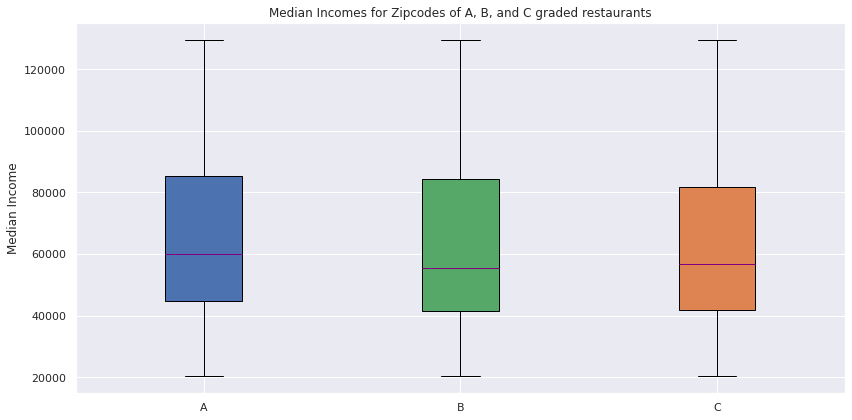

In [61]:
fig, ax = plt.subplots(figsize=(12,6))
bplot = ax.boxplot(inc_data, 
                    labels = ['A', 'B', 'C'],
                    patch_artist=True,
                    medianprops=dict(color='purple'))
colors = ['b', green, orange]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
ax.set_ylabel('Median Income')
plt.title('Median Incomes for Zipcodes of A, B, and C graded restaurants')

plt.tight_layout()

# plt.savefig('img/boxplot_income.png')
plt.show()

In [33]:
mean_A = unique_A.Median_Income.mean()
mean_B = unique_B.Median_Income.mean()
mean_C = unique_C.Median_Income.mean()


In [ ]:
# ___Revised to use boxplots___

# fig, axs = plt.subplots(3, 1, figsize=(20,10), constrained_layout=True)
# axs[0].hist(unique_A.Median_Income,bins=40, density=True, label='A grade')
# axs[1].hist(unique_B.Median_Income,bins=40, density=True, color=green, label='B grade')
# axs[2].hist(unique_C.Median_Income,bins=40, density=True, color=orange, label='C grade')

# axs[0].axvline(x= mean_A, linestyle='--', linewidth=2, color='black', label='Mean = {0:.0f}'.format(mean_A))
# axs[1].axvline(x= mean_B, linestyle='--', linewidth=2, color='black', label='Mean = {0:.0f}'.format(mean_B))
# axs[2].axvline(x= mean_C, linestyle='--', linewidth=2, color='black', label='Mean = {0:.0f}'.format(mean_C))

# axs[0].legend()
# axs[1].legend()
# axs[2].legend()


# fig.suptitle('Histograms of median incomes of the zipcodes of A, B, & C restaurants')
# plt.xlabel('Median Income')

# # plt.savefig('img/ABCincomes.png')
# plt.show()

### We can see a small but observable difference in the mean incomes between the A population and the B and C populations. Let's perform a Mann Whitney U test on all the pairs of populations to see if there is indeed a significant difference in the income levels.

$H_0: \text{The given pairs of populations of incomes are equal.}
\\
H_A: \text{The given pairs of populations of incomes are not equal.}
\\
\alpha = .05
$

$\text{Pairs to be tested: A-B, A-C, B-C}$

In [20]:
AB_Awins = count_winning_pairs(unique_A['Median_Income'], unique_B['Median_Income'])
AB_Bwins = count_winning_pairs(unique_B['Median_Income'], unique_A['Median_Income'])
print("Number of A Wins: {}".format(AB_Awins))
print("Number of B Wins: {}".format(AB_Bwins))
res = stats.mannwhitneyu(unique_A['Median_Income'], unique_B['Median_Income'], alternative="greater")
print(res)
print("p-value for A <= B: {:2.3f}".format(res.pvalue))

Number of A Wins: 11740269.0
Number of B Wins: 9737407.0
MannwhitneyuResult(statistic=11740269.0, pvalue=7.678232749294835e-08)
p-value for A <= B: 0.000


In [21]:
AC_Awins = count_winning_pairs(unique_A['Median_Income'], unique_C['Median_Income'])
AC_Cwins = count_winning_pairs(unique_C['Median_Income'], unique_A['Median_Income'])
print("Number of A Wins: {}".format(AC_Awins))
print("Number of C Wins: {}".format(AC_Cwins))
res = stats.mannwhitneyu(unique_A['Median_Income'], unique_C['Median_Income'], alternative="greater")
print(res)
print("p-value for A <= C: {:2.3f}".format(res.pvalue))

Number of A Wins: 2869195.0
Number of C Wins: 2399277.0
MannwhitneyuResult(statistic=2869195.0, pvalue=0.005552846600997878)
p-value for A <= C: 0.006


In [22]:
BC_Bwins = count_winning_pairs(unique_B['Median_Income'], unique_C['Median_Income'])
BC_Cwins = count_winning_pairs(unique_C['Median_Income'], unique_B['Median_Income'])
print("Number of B Wins: {}".format(BC_Bwins))
print("Number of C Wins: {}".format(BC_Cwins))
res = stats.mannwhitneyu(unique_B['Median_Income'], unique_C['Median_Income'], alternative="greater")
print(res)
print("p-value for B <= C: {:2.3f}".format(res.pvalue))

Number of B Wins: 152174.0
Number of C Wins: 153884.0
MannwhitneyuResult(statistic=152174.0, pvalue=0.5570885211284353)
p-value for B <= C: 0.557


$\text{A-B  p-value = 0.000} \\
\text{A-C  p-value = 0.006} \\
\text{B-C  p-value = 0.557} \\
\text{We can reject the null hypothesis that the two populations of incomes are equal for pairs A-B and A-C.} \\ 
\text{We fail to reject the null hypothesis for the third pair of populations, B-C.}$